### 1 Loading Dataset

In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


from my_datasets import MyDataset
from my_models import MyModel
from data.model_input import state_on, state_off_pos, state_off_imp
from data.model_gt import label_on, label_off_pos, label_off_imp 

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

False
cpu


In [118]:
# test_dataset with only one sample for overfitting
test_input = state_all[0][None,:]
test_label = label_all[0][None,:]

# Dataset & Dataloader  
data_on = np.concatenate((state_on, label_on), axis = 1) 
np.random.shuffle(data_on) 
state_train_on = data_on[:640, :8]
label_train_on = data_on[:640, 8:]
state_val_on = data_on[640:, :8]
label_val_on = data_on[640:, 8:] 

train_data_on = MyDataset(states = state_train_on, labels = label_train_on)
val_data_on = MyDataset(states = state_val_on, labels = label_val_on)  
overtest_data = MyDataset(states = test_input, labels = test_label)   

train_loader_on = DataLoader(dataset=train_data_on, batch_size=64, shuffle=True)
val_loader_on = DataLoader(dataset=val_data_on, batch_size=32, shuffle=True)
overtest_loader = DataLoader(dataset=overtest_data, batch_size=1, shuffle=True)

print("Train size: %i" % len(train_dataon))
print("Validation size: %i" % len(val_dataon))
print("Input size: ", train_data[0][0].shape)
print("Label size: ", train_data[0][1].shape)

Train size: 640
Validation size: 160
Input size:  (8,)
Label size:  (2,)


In [119]:
# Dataset & Dataloader  
data_on = np.concatenate((state_on, label_on), axis = 1) 
data_off_pos = np.concatenate((state_off_pos, label_off_pos), axis = 1) 
data_off_imp = np.concatenate((state_off_imp, label_off_imp), axis = 1)
data_all = np.concatenate((data_on, data_off_pos, data_off_imp), axis = 0)
np.random.shuffle(data_all) 
state_train = data_all[:1920, :8]
label_train = data_all[:1920, 8:]
state_val = data_all[1920:, :8]
label_val = data_all[1920:, 8:] 

train_data = MyDataset(states = state_train, labels = label_train)
val_data = MyDataset(states = state_val, labels = label_val)   

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=True)

print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Input size: ", train_data[0][0].shape)
print("Label size: ", train_data[0][1].shape)

Train size: 1920
Validation size: 480
Input size:  (8,)
Label size:  (2,)


### 2 Defining Neural Network

In [126]:
mynet = MyModel(neurons = [128,256,256,64]) 
print(mynet)

MyModel(
  (predictor): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [127]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

116,546 total parameters.
116,546 trainable parameters.


### 3 Training Neural network

In [133]:
mycriterion = nn.MSELoss() 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-6, eps = 1e-08) 

In [129]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss = 0.0  
    
    #Iterating through the minibatches of the data
    for i, data in enumerate(dataloader, 0): 
        X, y = data
        X = X.to(device)
        y = y.to(device)
        #print(X.shape,y.shape)
        if iftrain:  
            optimizer.zero_grad()
            y_pred = model(X.to(torch.float32))
            y_pred = y_pred.float()
            y = y.float()
            loss = criterion(y_pred, y)  
            loss.backward()             
            optimizer.step()            
            running_loss += loss.item() 
        else:
            y_pred = model(X.to(torch.float32))
            y_pred = y_pred.float()  
            y = y.float()
            loss = criterion(y_pred , y)  
            running_loss += loss.item()    
    return running_loss    

In [109]:
# test if the model will overfit with only one sample
max_epochs = 100 
train_history = []
val_history = []

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=overtest_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=overtest_loader,
                           iftrain=False)
    val_history.append(val_loss)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %2e, val_loss: %2e "% 
          (train_loss, val_loss))

Epoch  10/100, train_loss: 2.007283e-13, val_loss: 2.007283e-13 
Epoch  20/100, train_loss: 1.509903e-13, val_loss: 1.509903e-13 
Epoch  30/100, train_loss: 1.509903e-13, val_loss: 9.414691e-14 
Epoch  40/100, train_loss: 9.237056e-14, val_loss: 9.237056e-14 
Epoch  50/100, train_loss: 5.684342e-14, val_loss: 5.684342e-14 
Epoch  60/100, train_loss: 5.684342e-14, val_loss: 5.684342e-14 
Epoch  70/100, train_loss: 5.684342e-14, val_loss: 5.684342e-14 
Epoch  80/100, train_loss: 4.440892e-14, val_loss: 4.440892e-14 
Epoch  90/100, train_loss: 7.105427e-14, val_loss: 7.105427e-14 
Epoch 100/100, train_loss: 3.552714e-14, val_loss: 3.552714e-14 


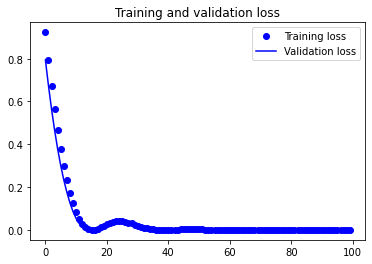

In [106]:
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [134]:
# start the main training process
max_epochs = 100
num_trainbatch = np.ceil(len(train_data_on)/64) 
num_valbatch = np.ceil(len(val_data_on)/32) 
train_history = []
val_history = []

min_loss = 100000
current_patience = 0
patience = 5

print('Start training!')

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader_on,
                           iftrain=True)
    train_history.append(train_loss/num_trainbatch)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader_on,
                           iftrain=False)
    val_history.append(val_loss/num_valbatch)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %e, val_loss: %e "% 
          (train_loss/num_trainbatch, val_loss/num_valbatch))
'''
    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        torch.save(mynet.state_dict(),'mynet.pth')
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}!".format(epoch+1)) 
            break   '''

print('FINISH.')

Start training!
Epoch  10/100, train_loss: 2.211600e-02, val_loss: 2.776888e-02 
Epoch  20/100, train_loss: 2.210471e-02, val_loss: 2.766145e-02 
Epoch  30/100, train_loss: 2.206736e-02, val_loss: 2.769181e-02 
Epoch  40/100, train_loss: 2.205542e-02, val_loss: 2.781208e-02 
Epoch  50/100, train_loss: 2.209191e-02, val_loss: 2.767429e-02 
Epoch  60/100, train_loss: 2.202571e-02, val_loss: 2.763930e-02 
Epoch  70/100, train_loss: 2.206813e-02, val_loss: 2.773630e-02 
Epoch  80/100, train_loss: 2.205638e-02, val_loss: 2.774321e-02 
Epoch  90/100, train_loss: 2.207662e-02, val_loss: 2.774042e-02 
Epoch 100/100, train_loss: 2.192343e-02, val_loss: 2.762650e-02 
FINISH.


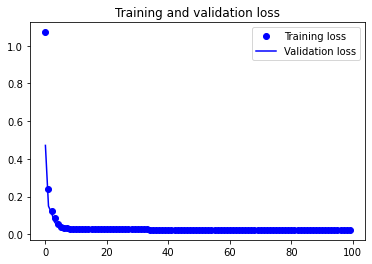

In [131]:
# plot the train&validation loss curve 
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [135]:
# save trained model
torch.save(mynet.state_dict(),'mynet.pth')

In [43]:
mynet.load_state_dict(torch.load('mynet.pth'))

<All keys matched successfully>

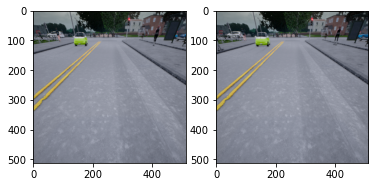

In [44]:
# do model inference
FOLDER = "/home/changyao/intellisys/week4/stationary/episode0/"
start_frame = 0
end_frame = 3
img1 = cv2.imread(FOLDER + 'CameraRGB0/image_%05d.png' % start_frame)
img2 = cv2.imread(FOLDER + 'CameraRGB0/image_%05d.png' % end_frame)
img1_rgb = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(img1_rgb)
plt.subplot(1,2,2)
plt.imshow(img2_rgb) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


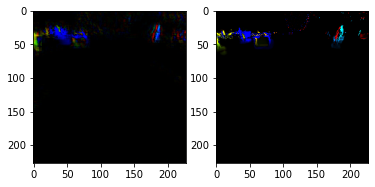

In [45]:
# show inference 
  
img1_scaled = cv2.resize(img1,(227,227)) 
img2_scaled = cv2.resize(img2,(227,227))  
img1_cat = img1_scaled.transpose(2,0,1)[None,:,:,:]
img2_cat = img2_scaled.transpose(2,0,1)[None,:,:,:]# (3,227,227)
two_img = np.concatenate((img1_cat, img2_cat), axis = 0)[None,:,:,:,:] #1,2,3,227,227 
two_img_ts = torch.from_numpy(two_img)  

# prediction
y_pred = mynet(two_img_ts.to(torch.float32))# tensor (1,3,227,227) 
y_pred_num = y_pred.detach().numpy() 
y_pred_img = y_pred_num.squeeze().transpose(1,2,0)# (227,227,3) 
plt.subplot(1,2,1)
plt.imshow(y_pred_img/100) 

# load the ground truth
y = dict_train_data[(0,0,3)]
y_scaled = cv2.resize(y,(227,227))
plt.subplot(1,2,2)
plt.imshow(y_scaled * 10) 
 

(-0.5, 226.5, 226.5, -0.5)

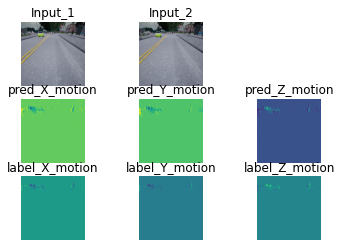

In [46]:
# show comparison between prediction and ground truth
plt.subplot(3,3,1)
plt.title('Input_1')  
plt.imshow(img1_rgb)
plt.axis('off') 
plt.subplot(3,3,2)
plt.title('Input_2') 
plt.imshow(img2_rgb)
plt.axis('off') 

plt.subplot(3,3,4)
plt.title('pred_X_motion')
plt.imshow(y_pred_img[:,:,0]/1000)
plt.axis('off') 
plt.subplot(3,3,5)
plt.title('pred_Y_motion')
plt.imshow(y_pred_img[:,:,1]/1000)
plt.axis('off') 
plt.subplot(3,3,6)
plt.title('pred_Z_motion')
plt.imshow(y_pred_img[:,:,2]/1000)
plt.axis('off') 
    
y = dict_train_data[(0,0,3)]
y_scaled = cv2.resize(y,(227,227)) 

plt.subplot(3,3,7)
plt.title('label_X_motion')
plt.imshow(y_scaled[:,:,0])
plt.axis('off') 
plt.subplot(3,3,8)
plt.title('label_Y_motion')
plt.imshow(y_scaled[:,:,1])
plt.axis('off') 
plt.subplot(3,3,9)
plt.title('label_Z_motion')
plt.imshow(y_scaled[:,:,2])
plt.axis('off') 

In [47]:
# Compute MSE Loss with single sample
y_ts = torch.from_numpy(y)  
loss_fn = nn.MSELoss() 
y_pred_img_ts = torch.tensor(y_pred_img)
y_scaled_ts = torch.tensor(y_scaled)
loss = loss_fn(y_pred_img_ts, y_scaled_ts*1000)
print(loss)

tensor(199.3105, dtype=torch.float64)
